# Assigment 1
**Author: Adrian Alarcon**

**About🚀**

The current project, as part of the course of Enterprise Data Science, is an end-to-end machine learning project where the ultimate goal is to predict the value of a soccer player (in euros) based on their characteristics such as ratings in every skill, club, years of contract, salary, release clause, among others. This project included three parts:

1. Data extraction: the dataset was created scrapping the webpage [sofifa.com](https://sofifa.com/players) where the features has been extracted. You can find more detailed about the data extraction process in the `data_extract.py` file.
2. Data cleaning: several steps in terms of data cleaning has been made such as spliting values and getting correct format of variables.
3. Training & evaluating a machine learning: in this step, feature engineering process and validation schemas has been proposed. To test the model, I have decided to split the dataset in three parts: train, test, validation. Train and test have been used to training the model and calibrate hyperparameter, while validation dataset was used to validate the final model and the final metrics

## Libraries & environment setup

In [1]:
## Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import catboost
import optuna
import re
import os
import joblib
import pickle
import json
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, KFold, train_test_split
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
os.chdir('/Users/aladelca/Library/CloudStorage/OneDrive-McGillUniversity/MMA/Enterprise Data Science/repo/enterprise_data_science/')

## Read data    

In [3]:
data_path = 'https://raw.githubusercontent.com/aladelca/enterprise_data_science/main/data_extract/players_all.csv'
data_path = 'data_extract/players_all.csv'
data = pd.read_csv(data_path, index_col=0)
print(data.shape)
data.head()

(5100, 78)


,name,Age,Overall rating,Potential,Team & Contract,ID,Height,Weight,foot,Best overall,Best position,Growth,Joined,Loan date end,Value,Wage,Release clause,Total attacking,Crossing,Finishing,Heading accuracy,Short passing,Volleys,Total skill,Dribbling,Curve,FK Accuracy,Long passing,Ball control,Total movement,Acceleration,Sprint speed,Agility,Reactions,Balance,Total power,Shot power,Jumping,Stamina,Strength,Long shots,Total mentality,Aggression,Interceptions,Att. Position,Vision,Penalties,Composure,Total defending,Defensive awareness,Standing tackle,Sliding tackle,Total goalkeeping,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Total stats,Base stats,Weak foot,Skill moves,Attacking work rate,Defensive work rate,International reputation,Body type,Real face,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defending / Pace,Physical / Positioning,Traits,PlayStyles,PlayStyles +,Number of playstyles,Unnamed: 78
0,Vini Jr. LW ST,22,89,94,Real Madrid\n2018 ~ 2027,238794,"176cm / 5'9""",73kg / 161lbs,Right,89,LW,5,"Jul 12, 2018",NaN,€158.5M,€310K,€336.8M,369,78,89,50,80,72,398,92,77,62,77,90,454,95,95,94,86,84,378,76,74,84,64,80,317,58,26,87,81,65,79,75,32,25,18,36,5,7,7,7,10,2027,442,4,5,High,High,5,Lean (170-185),Yes,95,82,78,90,29,68,NaN,Finesse Shot Chip Shot Rapid Flair First Touch...,Quick Step +,7,NaN
1,A. Lunin GK,24,76+2,83+2,Real Madrid\n2018 ~ 2024,243952,"191cm / 6'3""",83kg / 183lbs,Right,76,GK,7,"Jul 2, 2018",NaN,€13M,€67K,€29.3M,72,15,8,12,25,12,81,11,14,15,26,15,210,39,35,36,75+2,25,217,56+2,61+1,32,61,7,131,22,19,11,60,19,56,46,22,13,11,375,76+2,73+2,74+2,75+2,77+2,1132,412,3,1,Medium,Medium,1,Normal (185+),Yes,76,73,74,77,37,75,NaN,Footwork Rush Out,NaN,2,NaN
2,J. Bellingham CAM CM,20,87,92,Real Madrid\n2023 ~ 2029,252371,"186cm / 6'1""",75kg / 165lbs,Right,89,CAM,5,"Jul 1, 2023",NaN,€118.5M,€190K,€251.8M,383,66,86,69,88,74,388,87,73,56,86,86,402,78,76,81,88,79,407,79,80,93,75,80,404,85,82,87,86,64,85,233,77,79,77,48,14,11,10,5,8,2265,486,4,4,High,High,4,Lean (185+),Yes,77,82,81,86,78,82,NaN,Intercept Slide Tackle Technical Flair,Relentless +,5,NaN
3,R. Højlund ST,20,77,89,Manchester United\n2023 ~ 2028,259399,"191cm / 6'3""",79kg / 174lbs,Left,79,ST,12,"Aug 5, 2023",NaN,€25.5M,€77K,€53.6M,325,38,78,70,71+1,68,306,76+1,58,48,49,75-1,380,84,86,69,78+3,63,403,82+4,88,78+3,85,70,322,82+2,28,79+1,63+5,70,75+3,79,32+5,28,19,50,12,8,9,14,7,1865,409,3,3,Medium,High,1,Normal (185+),No,85,76,58,74,33,83,NaN,Rapid Flair Quick Step,NaN,3,NaN
4,K. Havertz CAM RW ST,24,82,87,Arsenal\n2023 ~ 2028,235790,"190cm / 6'3""",82kg / 181lbs,Left,85,CAM,5,"Jun 28, 2023",NaN,€46M,€110K,€88.6M,398,74,81,80,83,80,385,84,84,53,79,85,382,75,81,75,83,68,382,76,82,77,69,78,327,52,38,83,81,73,84,123,39,46,38,47,6,8,11,10,12,2044,432,4,4,Medium,Medium,3,Unique,Yes,78,79,79,83,45,68,NaN,Chip Shot Technical First Touch Trivela,NaN,4,NaN


## Data cleaning

In [4]:
## Constants
FINAL_COLUMNS = [
    'foot',
    'Best position',
    'Defensive work rate',
    'Body type',
    'Traits',
    'PlayStyles',
    'PlayStyles +',
    'club',
    'loan',
    'Age',
    'wage_euros',
    'release_clause_euros',
    'Best overall',
    'Growth',
    'Total attacking',
    'Total skill',
    'Total movement',
    'Total power',
    'Total mentality',
    'Total defending',
    'Total goalkeeping',
    'Total stats',
    'Base stats',
    'Weak foot',
    'Skill moves',
    'International reputation',
    'Pace / Diving',
    'Shooting / Handling',
    'Dribbling / Reflexes',
    'Defending / Pace',
    'Physical / Positioning',
    'Number of playstyles',
    'height_cm',
    'weight_kg',
    'total_potential',
    'contract_duration_years',
    'contract_years_left',
    'total_crossing',
    'total_finishing',
    'total_heading_accuracy',
    'total_short_passing',
    'total_volleys',
    'total_dribbling',
    'total_curve',
    'total_fk_accuracy',
    'total_long_passing',
    'total_ball_control',
    'total_acceleration',
    'total_sprint_speed',
    'total_agility',
    'total_reactions',
    'total_balance',
    'total_shot_power',
    'total_jumping',
    'total_stamina',
    'total_strength',
    'total_long_shots',
    'total_aggression',
    'total_interceptions',
    'total_att__position',
    'total_vision',
    'total_penalties',
    'total_composure',
    'total_defensive_awareness',
    'total_standing_tackle',
    'total_gk_diving',
    'total_gk_handling',
    'total_gk_positioning',
    'total_gk_reflexes',
    'total_overall_rating'
]

columns = [
    'Crossing',
    'Potential',
    'Finishing',
    'Heading accuracy',
    'Short passing',
    'Volleys',
    'Dribbling',
    'Curve',
    'FK Accuracy',
    'Long passing',
    'Ball control',
    'Acceleration',
    'Sprint speed',
    'Agility',
    'Reactions',
    'Balance',
    'Shot power',
    'Jumping',
    'Stamina',
    'Strength',
    'Long shots',
    'Aggression',
    'Interceptions',
    'Att. Position',
    'Vision',
    'Penalties',
    'Composure',
    'Defensive awareness',
    'Standing tackle',
    'GK Diving',
    'GK Handling',
    'GK Kicking',
    'GK Positioning',
    'GK Reflexes',
    'Overall rating'
]

TARGET = [
    'value_euros',
    ]
CAT_VARIABLES = [
    'foot',
    'Best position',
    'Defensive work rate',
    'Body type',
    'Traits',
    'PlayStyles',
    'PlayStyles +',
    'club',
    'loan'
]

NUM_VARIABLES = list(set(FINAL_COLUMNS) - set(CAT_VARIABLES))
index_cat_variables = [FINAL_COLUMNS.index(var) for var in CAT_VARIABLES if var in FINAL_COLUMNS]


### Functions for data cleaning

In [5]:
### Data cleaning

def get_height(data):
    df_height = data['Height'].str.split('/', expand=True)
    df_height.columns = ['height_cm','height_inch']
    data['height_cm'] = df_height['height_cm'].str.replace('cm','')
    data['height_cm'] = data['height_cm'].astype(int) 
    return data

def get_weight(data):
    df_weight = data['Weight'].str.split('/', expand=True)
    df_weight.columns = ['weight_kg','height_lbs']
    data['weight_kg'] = df_weight['weight_kg'].str.replace('kg','')
    data['weight_kg'] = data['weight_kg'].astype(int) 
    return data

def extract_year(string):
    try:
        match = re.search(r'\b\d{4}\b', string)
        year_extracted = match.group()
        return year_extracted
    except:
        return string

def manage_currency(column_name,final_column_name, data):
    data[column_name] = data[column_name].str.replace('€','')
    data['factor'] = np.where(data[column_name].str.contains('M'),1000000, np.where(data[column_name].str.contains('K'),1000,1))
    data[column_name] = data[column_name].str.replace('M','')
    data[column_name] = data[column_name].str.replace('K','')
    data[column_name] = data[column_name].astype(float)
    data[final_column_name] = data['factor'] * data[column_name]
    return data

def fill_columns(column_name, new_column_name, data):

    df_potential = data[column_name].str.split('[-,+]', expand=True).fillna(0).astype(int)
    data[new_column_name] = df_potential[0] + df_potential[1]
    return data

def get_contract_team_variables(current_year,data):
    df_club = data['Team & Contract'].str.split('\n', expand = True)
    df_club.columns = ['club','contract']
    data['club'] = df_club['club']
    data['loan'] = df_club['contract'].str.contains('On loan')
    df_club['contract_end'] = df_club['contract'].apply(lambda x: extract_year(x) if 'On loan' in x else x)
    df_contract = df_club['contract_end'].str.split('~', expand = True)
    df_contract.columns = ['start','end']
    df_contract['end'] = np.where(df_contract['end'].isna(),df_contract['start'], df_contract['end'])
    data['contract_end'] = df_contract['end']
    data['contract_start'] = data['Joined'].apply(lambda x: extract_year(x))
    data['contract_end'] = data['contract_end'].str.strip()
    data['contract_end'] = np.where(data['contract_end'] == 'Free','', data['contract_end'])
    data['contract_end'] = data['contract_end'].replace('',np.nan)
    data['contract_end'] = data['contract_end'].astype(float)
    data['contract_duration_years'] = data['contract_end'] - data['contract_start'].astype(float)
    data['contract_years_left'] = np.where(data['contract_end'] - 2024>=0, data['contract_end'] - current_year, np.nan)
    return data

def get_total_values(data, columns):
    for i in columns:
        new_column = 'total_'+i.lower()
        new_column = new_column.replace(' ','_')
        new_column = new_column.replace('.','_')
        data = fill_columns(i,new_column,data)
    return data

def get_final_columns(data, columns):
    data = data[columns]
    return data

def data_preprocess(data):
    
    data = get_height(data)
    data = get_weight(data)
    data = manage_currency('Value','value_euros',data)
    data = manage_currency('Wage','wage_euros',data)
    data = manage_currency('Release clause','release_clause_euros',data)
    data = get_contract_team_variables(2024, data)
    data = get_total_values(data, columns)
    data = get_final_columns(data,FINAL_COLUMNS + TARGET)
    return data



In [6]:
data = data_preprocess(data)
data.head()

,foot,Best position,Defensive work rate,Body type,Traits,PlayStyles,PlayStyles +,club,loan,Age,wage_euros,release_clause_euros,Best overall,Growth,Total attacking,Total skill,Total movement,Total power,Total mentality,Total defending,Total goalkeeping,Total stats,Base stats,Weak foot,Skill moves,International reputation,Pace / Diving,Shooting / Handling,Dribbling / Reflexes,Defending / Pace,Physical / Positioning,Number of playstyles,height_cm,weight_kg,total_potential,contract_duration_years,contract_years_left,total_crossing,total_finishing,total_heading_accuracy,total_short_passing,total_volleys,total_dribbling,total_curve,total_fk_accuracy,total_long_passing,total_ball_control,total_acceleration,total_sprint_speed,total_agility,total_reactions,total_balance,total_shot_power,total_jumping,total_stamina,total_strength,total_long_shots,total_aggression,total_interceptions,total_att__position,total_vision,total_penalties,total_composure,total_defensive_awareness,total_standing_tackle,total_gk_diving,total_gk_handling,total_gk_positioning,total_gk_reflexes,total_overall_rating,value_euros
0,Right,LW,High,Lean (170-185),NaN,Finesse Shot Chip Shot Rapid Flair First Touch...,Quick Step +,Real Madrid,False,22,310000.0,336800000.0,89,5,369,398,454,378,317,75,36,2027,442,4,5,5,95,82,90,29,68,7,176,73,94,9.0,3.0,78,89,50,80,72,92,77,62,77,90,95,95,94,86,84,76,74,84,64,80,58,26,87,81,65,79,32,25,5,7,7,10,89,158500000.0
1,Right,GK,Medium,Normal (185+),NaN,Footwork Rush Out,NaN,Real Madrid,False,24,67000.0,29300000.0,76,7,72,81,210,217,131,46,375,1132,412,3,1,1,76,73,77,37,75,2,191,83,85,6.0,0.0,15,8,12,25,12,11,14,15,26,15,39,35,36,77,25,58,62,32,61,7,22,19,11,60,19,56,22,13,78,75,77,79,78,13000000.0
2,Right,CAM,High,Lean (185+),NaN,Intercept Slide Tackle Technical Flair,Relentless +,Real Madrid,False,20,190000.0,251800000.0,89,5,383,388,402,407,404,233,48,2265,486,4,4,4,77,82,86,78,82,5,186,75,92,6.0,5.0,66,86,69,88,74,87,73,56,86,86,78,76,81,88,79,79,80,93,75,80,85,82,87,86,64,85,77,79,14,11,5,8,87,118500000.0
3,Left,ST,High,Normal (185+),NaN,Rapid Flair Quick Step,NaN,Manchester United,False,20,77000.0,53600000.0,79,12,325,306,380,403,322,79,50,1865,409,3,3,1,85,76,74,33,83,3,191,79,89,5.0,4.0,38,78,70,72,68,77,58,48,49,76,84,86,69,81,63,86,88,81,85,70,84,28,80,68,70,78,37,28,12,8,14,7,77,25500000.0
4,Left,CAM,Medium,Unique,NaN,Chip Shot Technical First Touch Trivela,NaN,Arsenal,False,24,110000.0,88600000.0,85,5,398,385,382,382,327,123,47,2044,432,4,4,3,78,79,83,45,68,4,190,82,87,5.0,4.0,74,81,80,83,80,84,84,53,79,85,75,81,75,83,68,76,82,77,69,78,52,38,83,81,73,84,39,46,6,8,10,12,82,46000000.0


## Split datasets into Train and Validation

All the experimentation will be using the train dataset. Validation dataset would be used to test the final solution after experimentation

In [7]:
x = data[FINAL_COLUMNS]
y = data[TARGET]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=123)

train = pd.concat([x_train, y_train], axis = 1)



## Exploratory data analysis

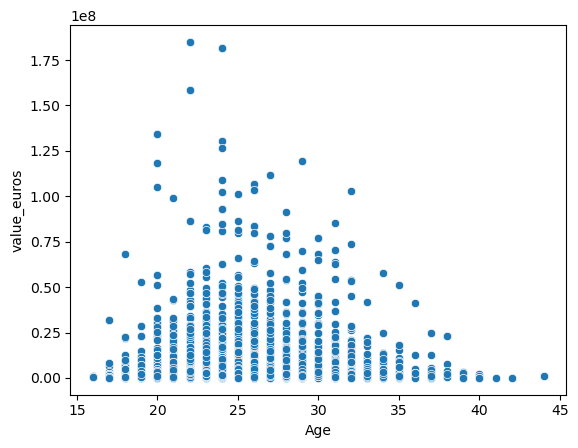

In [111]:
sns.scatterplot(data = train, x = 'Age', y = 'value_euros')
plt.show()

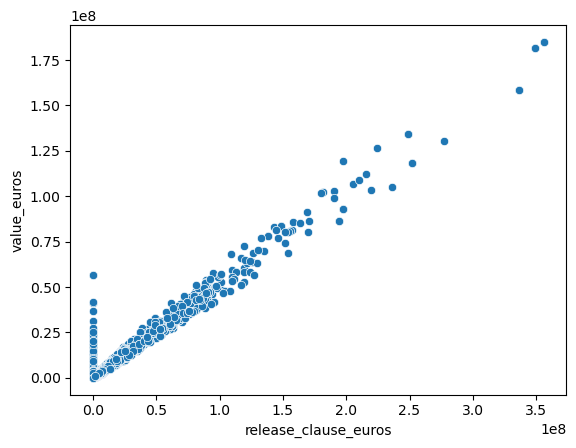

In [112]:
sns.scatterplot(data = train, x = 'release_clause_euros', y = 'value_euros')
plt.show()

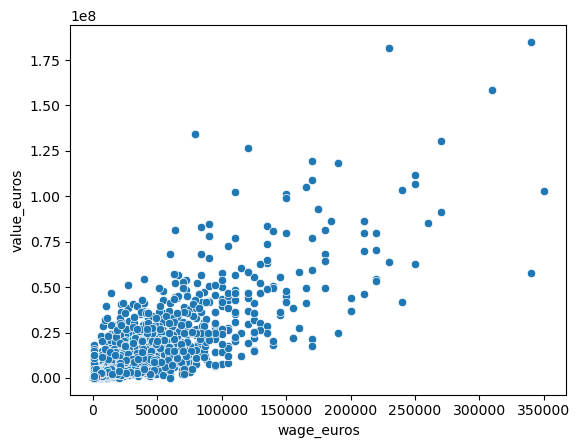

In [113]:
sns.scatterplot(data = train, x = 'wage_euros', y = 'value_euros')
plt.show()

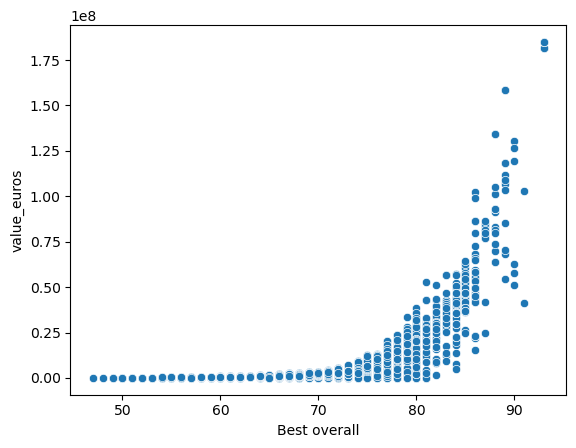

In [114]:
sns.scatterplot(data = train, x = 'Best overall', y = 'value_euros')
plt.show()

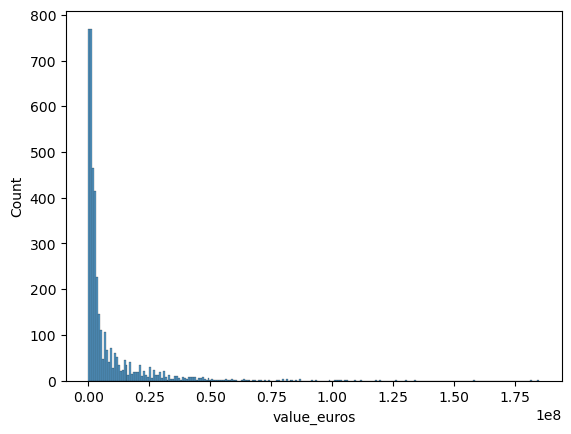

In [115]:
sns.histplot(data = train, x = 'value_euros')
plt.show()

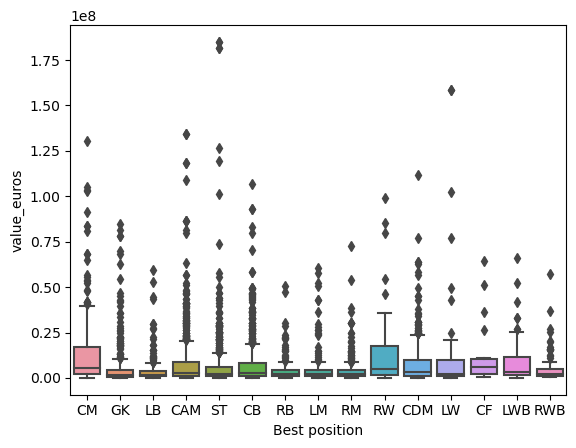

In [116]:
sns.boxplot(data = train, y = 'value_euros', x = 'Best position')
plt.show()

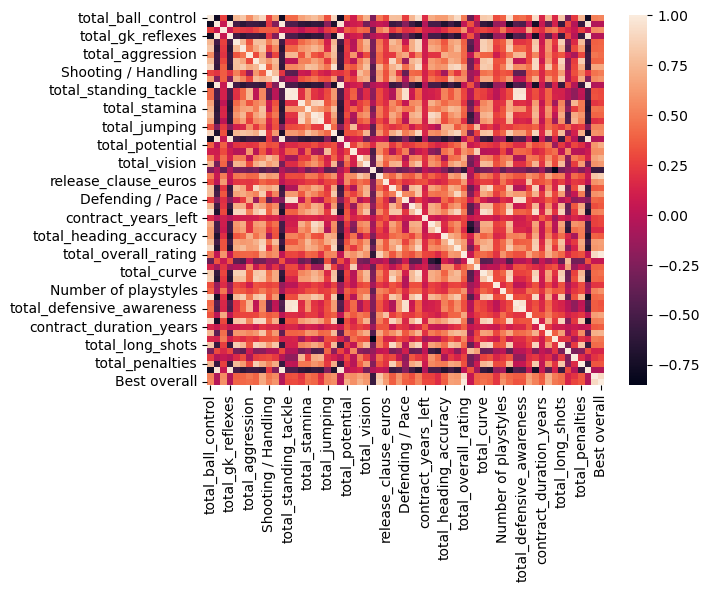

In [200]:
#plt.figure(figsize = (20,20))
sns.heatmap(train[NUM_VARIABLES].corr())
plt.show()

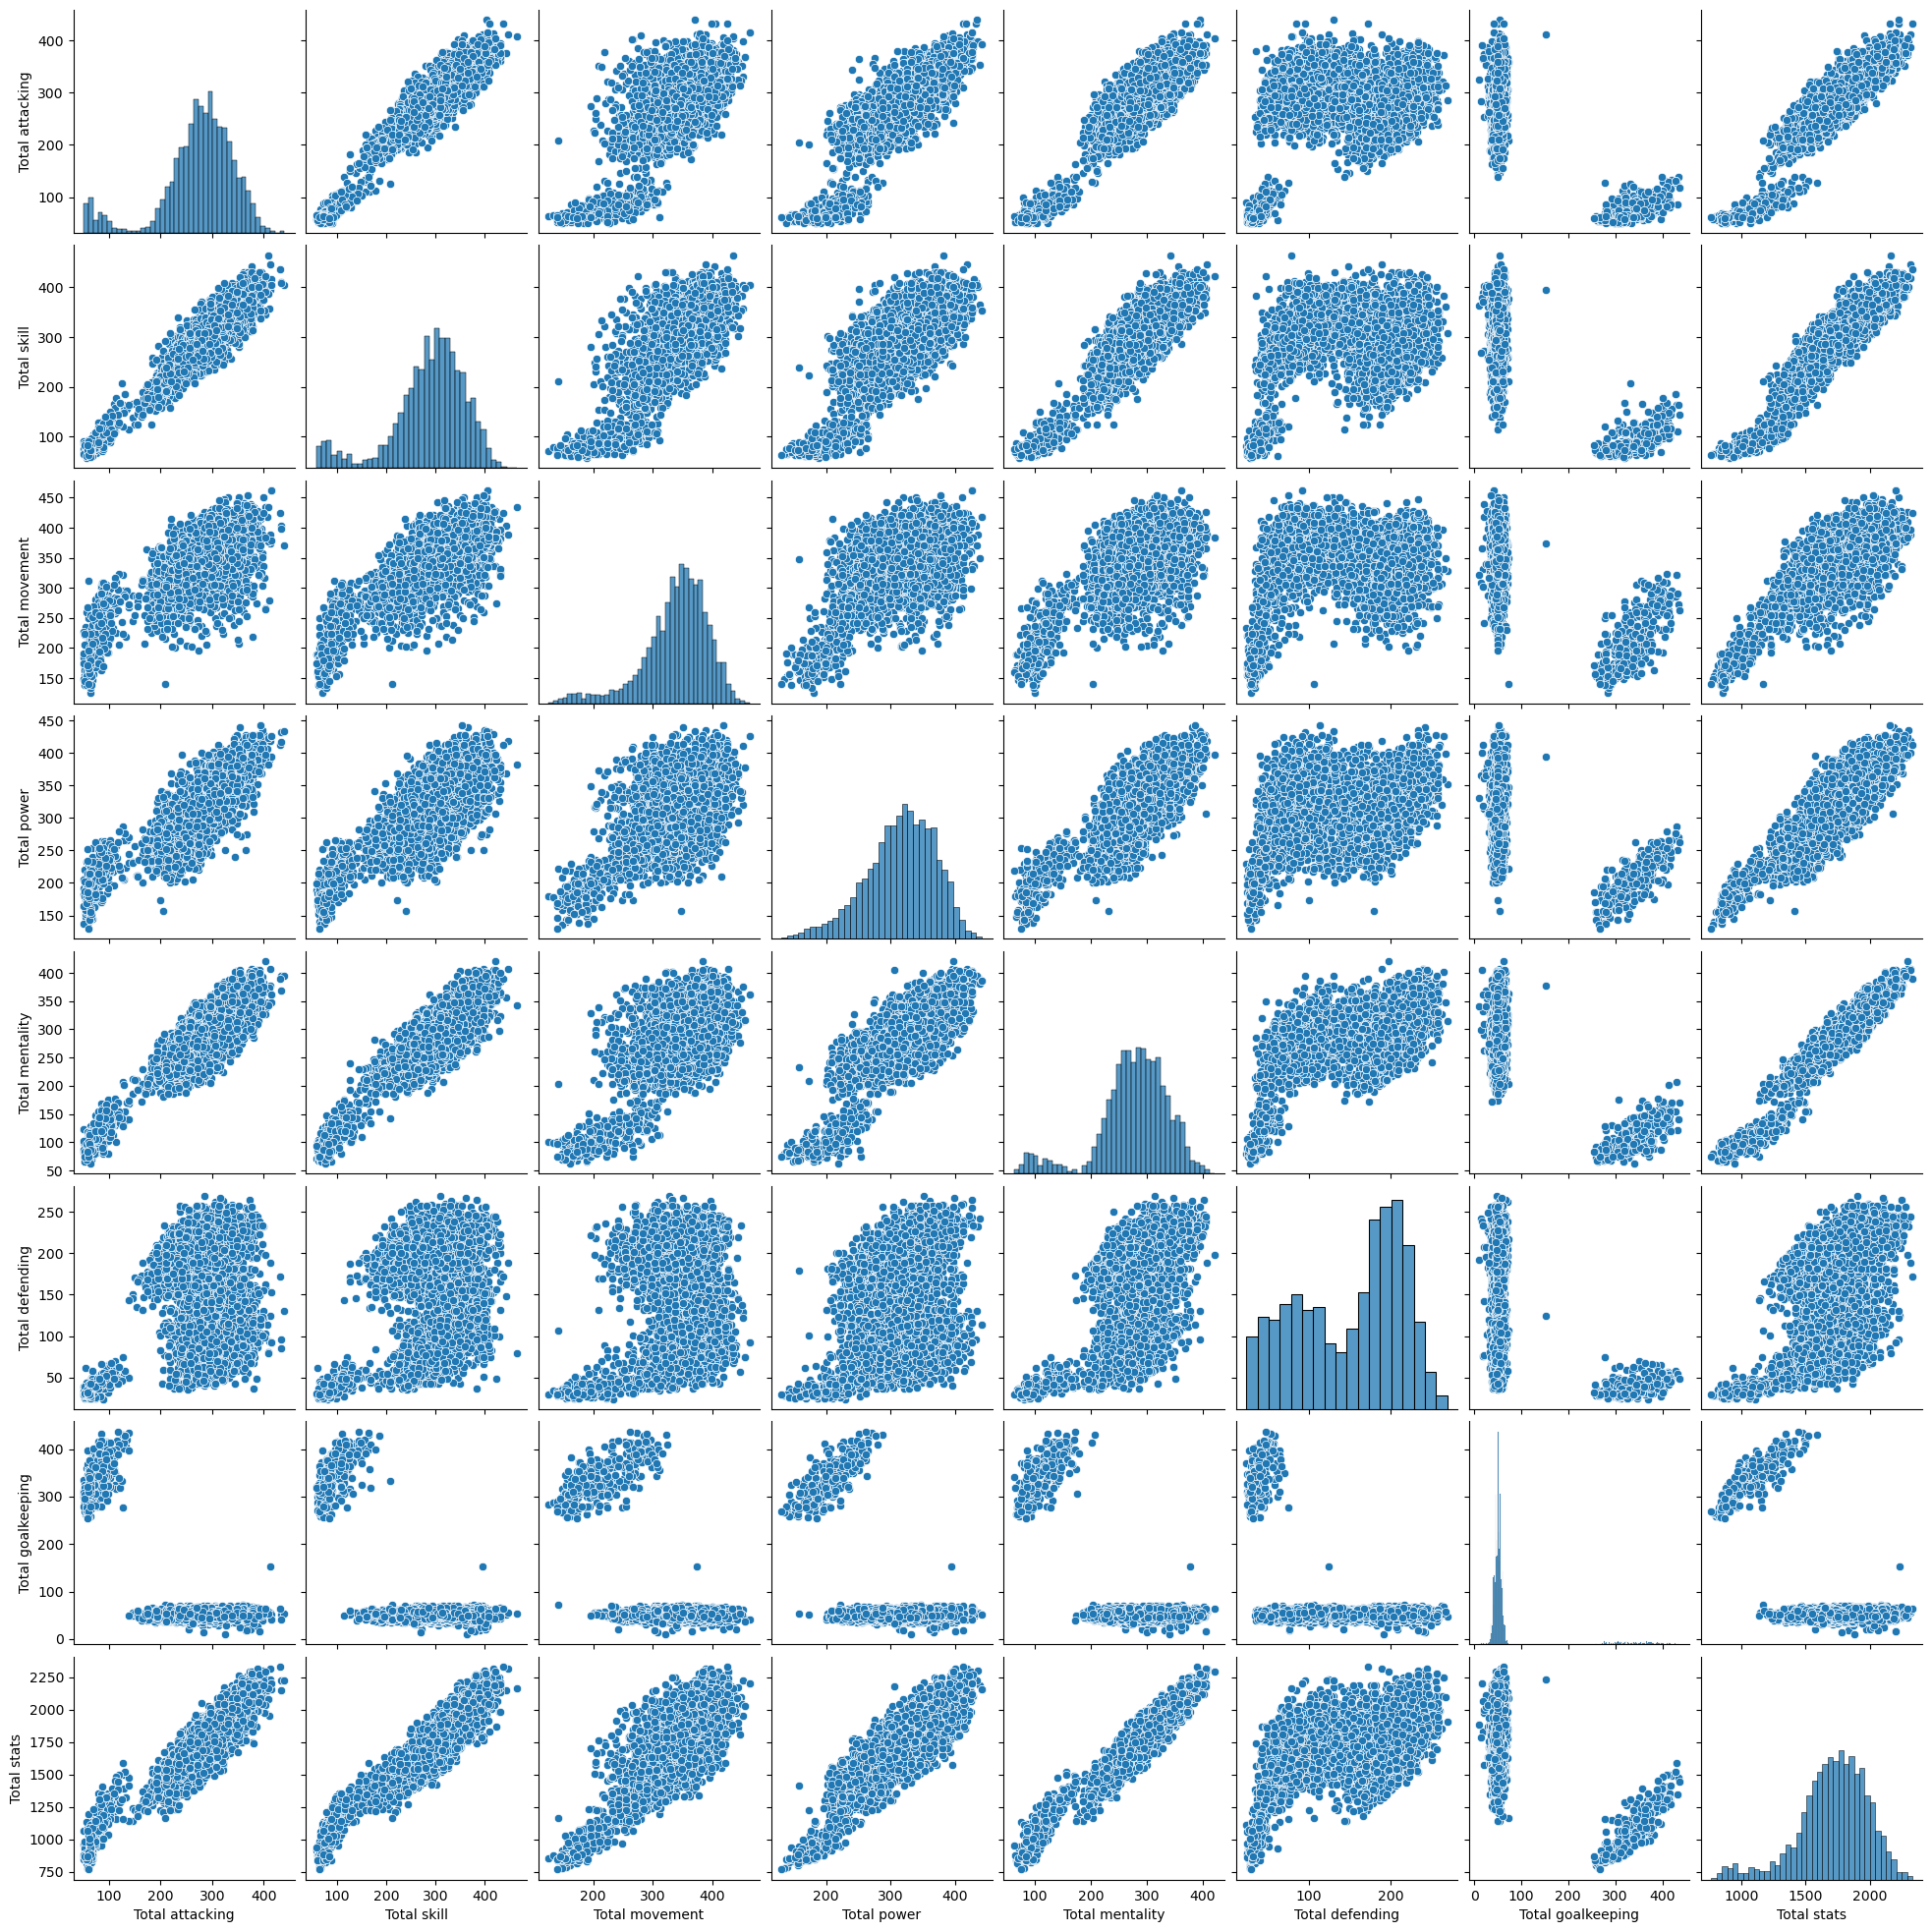

In [8]:
sns.pairplot(train[['Total attacking',
    'Total skill',
    'Total movement',
    'Total power',
    'Total mentality',
    'Total defending',
    'Total goalkeeping',
    'Total stats']])
plt.show()

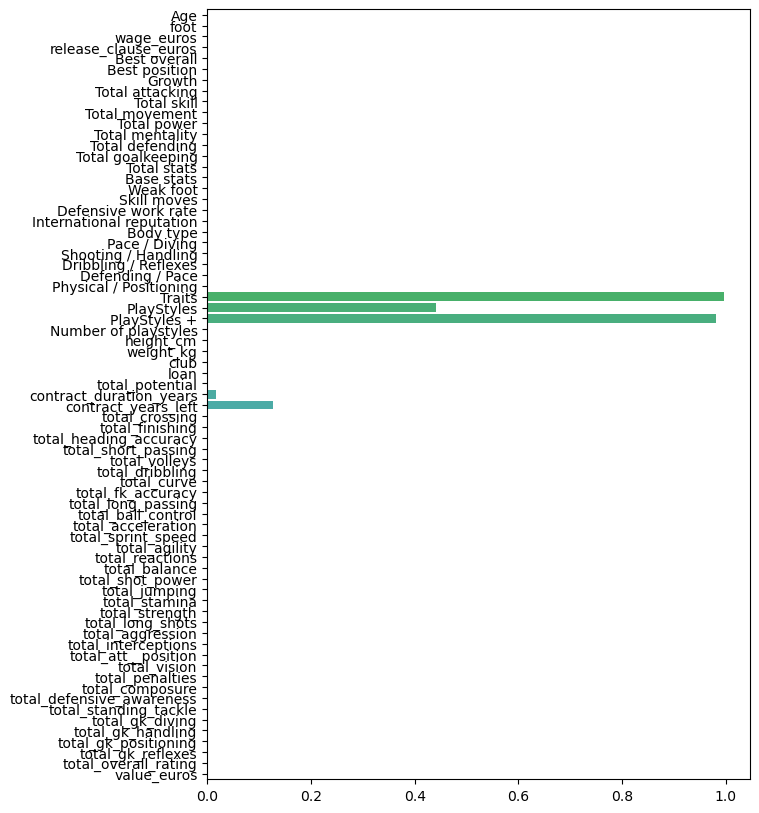

In [202]:
plt.figure(figsize = (7,10))
sns.barplot(x = train.isna().mean().values, y = train.isna().mean().index)
plt.show()

## Handling null values

In [234]:
## Filtering players without current contract

def filter_nulls(train):
    train = train[~train['contract_years_left'].isna()]
    return train

def handle_categorial_asis(train):
    return train
train_no_nulls = filter_nulls(train)

delete_nulls = FunctionTransformer(filter_nulls)
handle_categorical_nothing = FunctionTransformer(handle_categorial_asis)

In [269]:
preprocessor = ColumnTransformer(
    transformers=[
        ('mean_impute', SimpleImputer(strategy='mean'), NUM_VARIABLES)
    ])

## Scalling

In [206]:


esc_ = StandardScaler()
train_esc = esc_.fit_transform(train_no_nulls[NUM_VARIABLES])

## Applying PCA

In [207]:


n_components = 11
components = np.arange(1,n_components)
variances = []
for i in components:
    pca = PCA(n_components=i)
    pca.fit(train_esc)
    total_variance = np.sum(pca.explained_variance_ratio_)
    variances.append(total_variance)

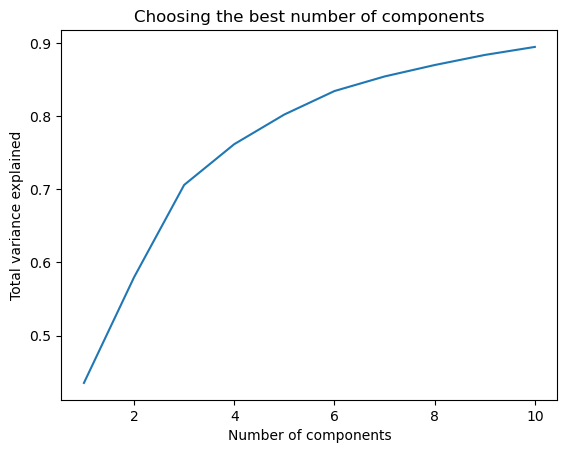

In [208]:
### Choosing the best number of components

sns.lineplot(x = components, y = variances)
plt.xlabel('Number of components')
plt.ylabel('Total variance explained')
plt.title('Choosing the best number of components')
plt.show()

In [228]:
### Using 6 components

pca = PCA(n_components=6)
train_pca = pd.DataFrame(pca.fit_transform(train_esc), index = train_no_nulls.index)
train_pca.head()

,0,1,2,3,4,5
364,-8.409960,5.242183,0.338995,0.515670,0.142632,-0.079159
3409,17.653621,-0.201252,1.991384,0.736427,2.243330,1.238958
2001,1.209057,-0.687453,-2.833601,-0.837982,-0.555015,-0.373189
283,-0.405567,-1.996124,-1.022470,-1.002877,0.356359,2.228101
5076,0.717768,-2.179093,0.869963,2.876425,-0.274653,-0.826764


## Setting different experiments

Description of each experiment

1. Exp1: Includes scalling numerical variables and applying PCA with 6 components. NULL values for numeric variables will be eliminated and, for categorical variables, impute with constant value. Modeling would be done using Catboost, which would handle categorical variables with its own engine.
2. Exp2: Includes scalling numerical variables and applying PCA with 6 components. NULL values for numeric variables will be imputed with mean and, for categorical variables, impute with constant value. Modeling would be done using Catboost, which would handle categorical variables with its own engine.
3. Exp3: Includes scalling numerical variables. NULL values for categorical variables would be imputed with constant value, NULL values for numeric values would enter as is to the model. Modeling would be done using Catboost, which would handle categorical variables with its own engine.

All the experiments would be evaluated using MAE

In [352]:
def generate_metrics(scores,n):
    test_r2_mean = np.mean(scores['test_r2'])
    test_r2_sd = np.std(scores['test_r2'])
    train_r2_mean = np.mean(scores['train_r2'])
    train_r2_sd = np.std(scores['train_r2'])
    test_mae = np.mean(-scores['test_neg_mean_absolute_error'])
    test_mae_sd = np.std(-scores['test_neg_mean_absolute_error'])
    train_mae = np.mean(-scores['train_neg_mean_absolute_error'])
    train_mae_sd = np.mean(-scores['train_neg_mean_absolute_error'])
    results = {'R2':{'mean':test_r2_mean,'sd':test_r2_sd},
               'MAE':{'mean':test_mae,'sd':test_mae_sd}}
    data_dict = {'k':np.arange(n),
                 'test':-scores['test_neg_mean_absolute_error'],
                 'train':-scores['train_neg_mean_absolute_error']}
    df = pd.DataFrame(data_dict).reset_index()
    g = sns.barplot(
    data=df.melt(id_vars = 'index', value_vars=["test", "train"]),
    y="value", hue="variable", x="index", ci=None
    )
    plt.title('Cross validation: MAE')

    
    plt.show()
    print(results)
    return results

In [404]:

#+ (len(FINAL_COLUMNS) - len(CAT_VARIABLES))
catboost_model = catboost.CatBoostRegressor(cat_features=np.array(index_cat_variables), verbose=False)
catboost_model_all_variables = catboost.CatBoostRegressor(cat_features=np.array(index_cat_variables) , verbose=False)
#catboost_model_all_variables = catboost.CatBoostRegressor(cat_features=CAT_VARIABLES , verbose=False)
esc = StandardScaler()

preprocessor_exp1 = ColumnTransformer(
    transformers=[
        ('handle_missing',SimpleImputer(strategy='constant', fill_value='NULL'), CAT_VARIABLES),
        ('num', Pipeline([
            
            ('scalling',StandardScaler()),
            ('pca',PCA(n_components=6))
            ]), NUM_VARIABLES),
        #('cat','passthrough', CAT_VARIABLES)
        
            ]
        )
preprocessor_exp2 = ColumnTransformer(
    transformers=[
        ('handle_missing',SimpleImputer(strategy='constant', fill_value='NULL'), CAT_VARIABLES),
        ('num', Pipeline([
            ('impute_mean',preprocessor),
            ('scalling',esc),
            ('pca',pca)
        ]), NUM_VARIABLES),
        
        #('cat','passthrough', CAT_VARIABLES)
            ]
        )

preprocessor_exp3 = ColumnTransformer(
    transformers=[
        #('num', Pipeline([
            #('impute_mean',preprocessor),
        #    ('scalling',esc),
            #('pca',pca)
        #]), NUM_VARIABLES),
        ('cat', Pipeline([
            ('handle_missing',SimpleImputer(strategy='constant', fill_value='NULL'))]), CAT_VARIABLES),
        #('cat','passthrough', CAT_VARIABLES)
        ('num', Pipeline([
            #('impute_mean',preprocessor),
            ('scalling',esc)]),NUM_VARIABLES)
            ]
        )


exp1 = Pipeline([
    #('filter_nulls', delete_nulls),
    ('preprocessing',preprocessor_exp1),
    ('catboost',catboost_model)
   ])


exp2 = Pipeline([
    
    ('preprocessing',preprocessor_exp2),
    ('catboost',catboost_model)
   ])

exp3 = Pipeline([
    
    ('preprocessing',preprocessor_exp3),
    ('catboost',catboost_model_all_variables)
   ])

kfold = KFold(n_splits=10, shuffle=True, random_state=123)

cv_scores_exp1 = cross_validate(exp1, train_no_nulls[FINAL_COLUMNS], train_no_nulls[TARGET], cv=kfold, return_train_score= True, scoring= ['r2','neg_mean_absolute_error'] )  
cv_scores_exp2 = cross_validate(exp2, train[FINAL_COLUMNS], train[TARGET], cv=kfold, return_train_score= True, scoring= ['r2','neg_mean_absolute_error'] )  
cv_scores_exp3 = cross_validate(exp3, train[FINAL_COLUMNS], train[TARGET], cv=kfold, return_train_score= True, scoring= ['r2','neg_mean_absolute_error'] )  



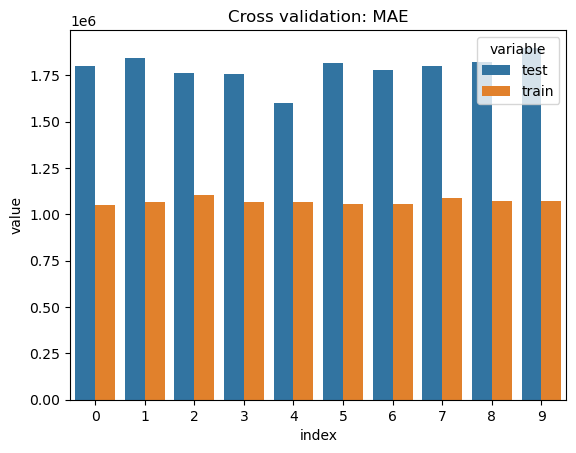

{'R2': {'mean': 0.9453180419318453, 'sd': 0.013034690286477307}, 'MAE': {'mean': 1788443.0306414838, 'sd': 73285.79352330686}}


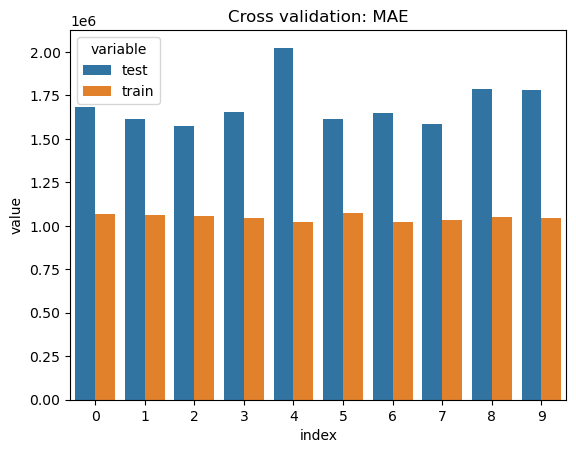

{'R2': {'mean': 0.9398029279718942, 'sd': 0.02327741918077003}, 'MAE': {'mean': 1695752.9586722222, 'sd': 129514.86923721051}}


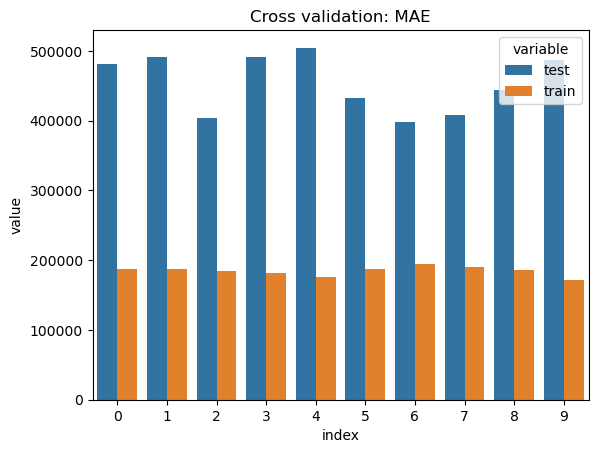

{'R2': {'mean': 0.9942617676188412, 'sd': 0.001405439998309461}, 'MAE': {'mean': 454200.53861639823, 'sd': 39310.80000783261}}


{'R2': {'mean': 0.9942617676188412, 'sd': 0.001405439998309461},
 'MAE': {'mean': 454200.53861639823, 'sd': 39310.80000783261}}

In [405]:
generate_metrics(cv_scores_exp1,10)
generate_metrics(cv_scores_exp2,10)
generate_metrics(cv_scores_exp3,10)

## Hyperparameter calibration

This process would be done with Optuna

In [429]:
def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'depth': trial.suggest_int('depth', 4, 16),
        #'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_seed': 123
    }
    catboost_model_all_variables = catboost.CatBoostRegressor(cat_features=np.array(index_cat_variables) , verbose=False, **params)
    preprocessor_exp3 = ColumnTransformer(
    transformers=[
        #('num', Pipeline([
            #('impute_mean',preprocessor),
        #    ('scalling',esc),
            #('pca',pca)
        #]), NUM_VARIABLES),
        ('cat', Pipeline([
            ('handle_missing',SimpleImputer(strategy='constant', fill_value='NULL'))]), CAT_VARIABLES),
        #('cat','passthrough', CAT_VARIABLES)
        ('num', Pipeline([
            #('impute_mean',preprocessor),
            ('scalling',esc)]),NUM_VARIABLES)
            ]
        )
    
    exp3 = Pipeline([
    
    ('preprocessing',preprocessor_exp3),
    ('catboost',catboost_model_all_variables)
   ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=123)
    # Use cross-validation to evaluate the pipeline
    cv_scores_exp3 = cross_validate(exp3, train_no_nulls[FINAL_COLUMNS], train_no_nulls[TARGET], cv=kfold, return_train_score= True, scoring= ['r2','neg_mean_absolute_error'] )  
    results = generate_metrics(cv_scores_exp3,5)
    return results['MAE']['mean']

[I 2024-01-21 11:29:31,923] A new study created in memory with name: no-name-cb75ceb8-6a73-4c04-afa5-0f3594af3f53


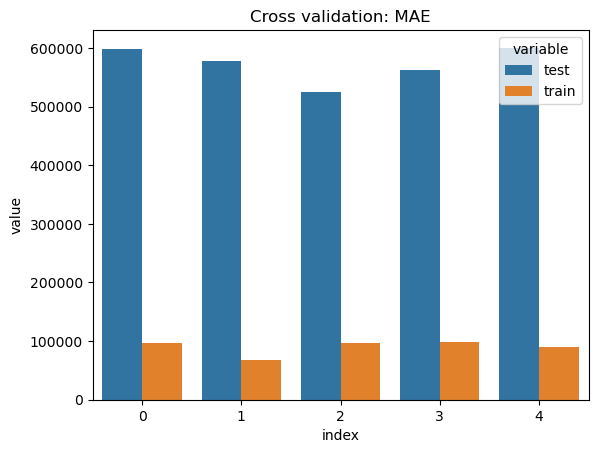

[I 2024-01-21 11:30:52,162] Trial 0 finished with value: 572418.3881121251 and parameters: {'iterations': 754, 'depth': 11}. Best is trial 0 with value: 572418.3881121251.


{'R2': {'mean': 0.9894283495165295, 'sd': 0.003942982918109612}, 'MAE': {'mean': 572418.3881121251, 'sd': 27657.973641176904}}


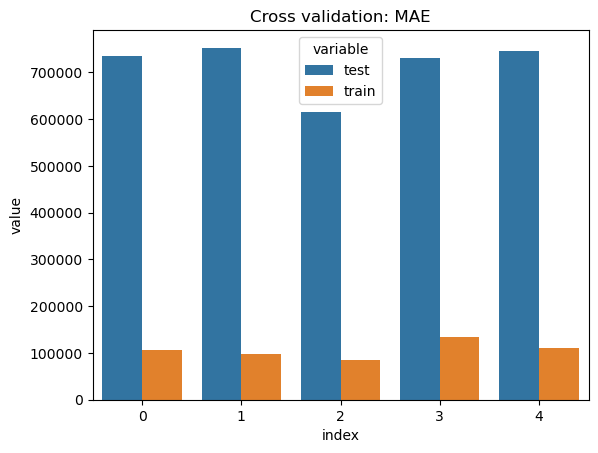

[I 2024-01-21 11:33:25,557] Trial 1 finished with value: 715731.2539596498 and parameters: {'iterations': 451, 'depth': 13}. Best is trial 0 with value: 572418.3881121251.


{'R2': {'mean': 0.9840448969097, 'sd': 0.006404495792726298}, 'MAE': {'mean': 715731.2539596498, 'sd': 51020.739911594115}}


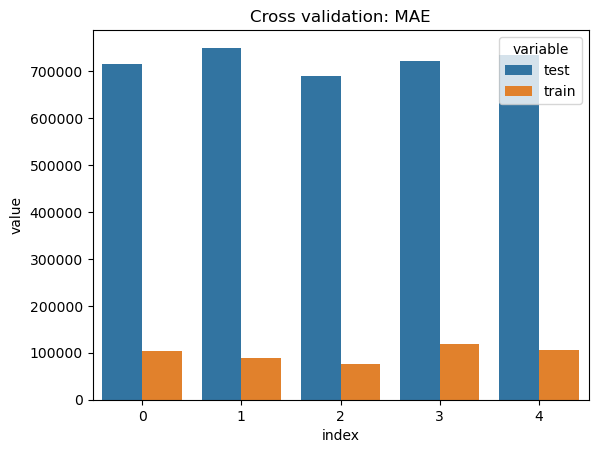

[I 2024-01-21 11:35:57,243] Trial 2 finished with value: 722181.3832540477 and parameters: {'iterations': 441, 'depth': 13}. Best is trial 0 with value: 572418.3881121251.


{'R2': {'mean': 0.9838866426304291, 'sd': 0.005015627973207041}, 'MAE': {'mean': 722181.3832540477, 'sd': 20139.18115564691}}


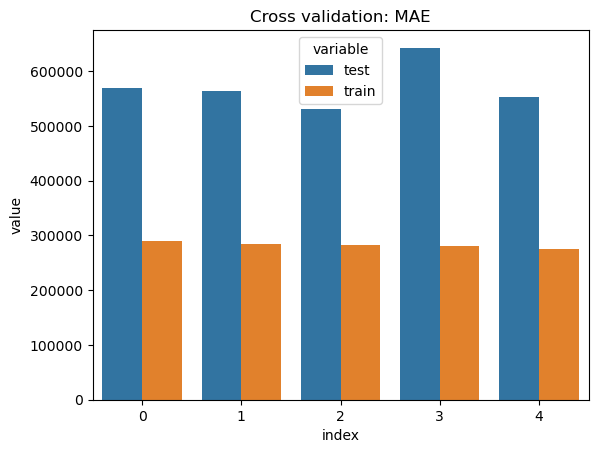

[I 2024-01-21 11:36:03,684] Trial 3 finished with value: 572131.1768892815 and parameters: {'iterations': 372, 'depth': 5}. Best is trial 3 with value: 572131.1768892815.


{'R2': {'mean': 0.9925460125732846, 'sd': 0.0016830020224173918}, 'MAE': {'mean': 572131.1768892815, 'sd': 37766.41280938791}}


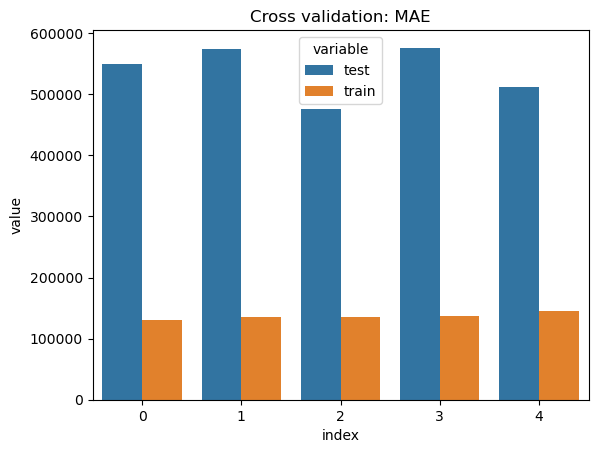

[I 2024-01-21 11:36:35,140] Trial 4 finished with value: 537162.0266678091 and parameters: {'iterations': 671, 'depth': 8}. Best is trial 4 with value: 537162.0266678091.


{'R2': {'mean': 0.9909336791775993, 'sd': 0.0038457516806367723}, 'MAE': {'mean': 537162.0266678091, 'sd': 38794.10711219469}}


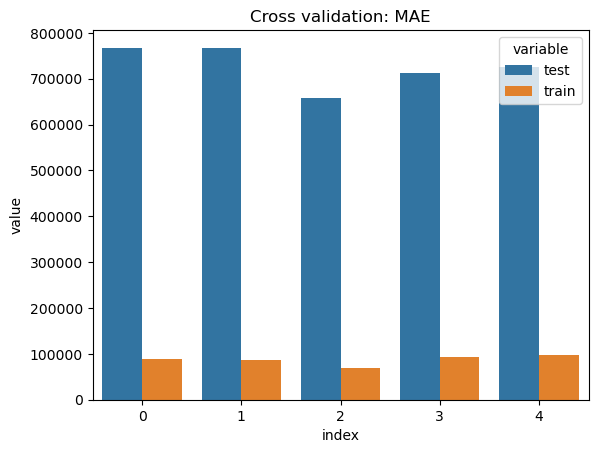

[I 2024-01-21 11:54:57,111] Trial 5 finished with value: 726110.7312190601 and parameters: {'iterations': 666, 'depth': 15}. Best is trial 4 with value: 537162.0266678091.


{'R2': {'mean': 0.9823456354710427, 'sd': 0.006045528165252638}, 'MAE': {'mean': 726110.7312190601, 'sd': 40160.39382113404}}


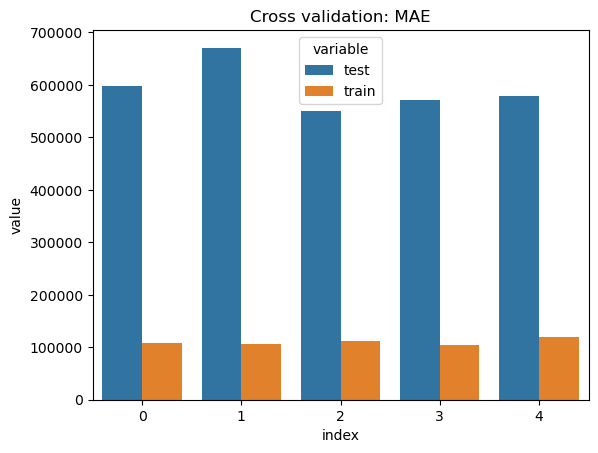

[I 2024-01-21 11:55:31,068] Trial 6 finished with value: 593821.4077255266 and parameters: {'iterations': 505, 'depth': 10}. Best is trial 4 with value: 537162.0266678091.


{'R2': {'mean': 0.9883622049250169, 'sd': 0.0042673893197014085}, 'MAE': {'mean': 593821.4077255266, 'sd': 41505.21213365475}}


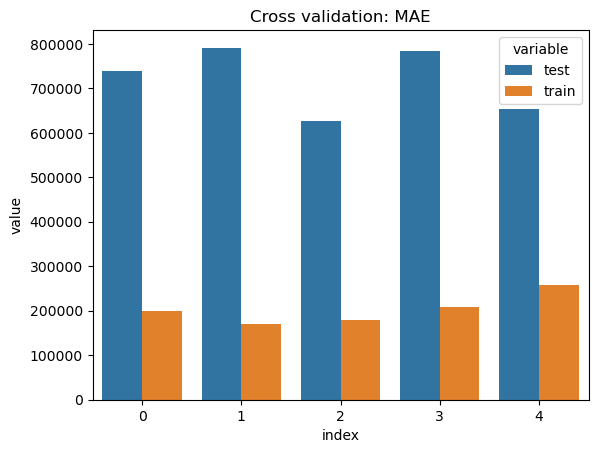

[I 2024-01-21 11:55:39,211] Trial 7 finished with value: 718478.7289944451 and parameters: {'iterations': 126, 'depth': 9}. Best is trial 4 with value: 537162.0266678091.


{'R2': {'mean': 0.9856144715937963, 'sd': 0.005250511677224155}, 'MAE': {'mean': 718478.7289944451, 'sd': 67463.07222343692}}


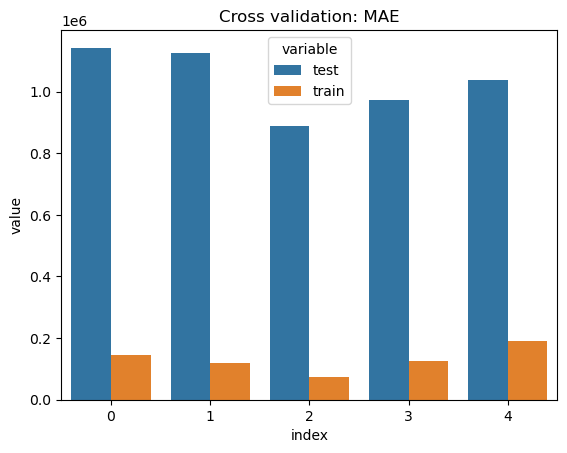

[I 2024-01-21 12:07:24,878] Trial 8 finished with value: 1033064.6854046419 and parameters: {'iterations': 168, 'depth': 16}. Best is trial 4 with value: 537162.0266678091.


{'R2': {'mean': 0.9688357405358936, 'sd': 0.01426767346374637}, 'MAE': {'mean': 1033064.6854046419, 'sd': 95395.3519940176}}


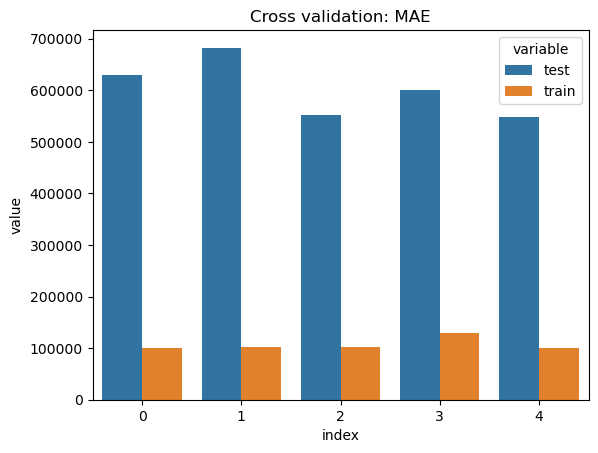

[I 2024-01-21 12:07:55,800] Trial 9 finished with value: 602829.4385781604 and parameters: {'iterations': 492, 'depth': 10}. Best is trial 4 with value: 537162.0266678091.


{'R2': {'mean': 0.987851755616943, 'sd': 0.0048782320262278}, 'MAE': {'mean': 602829.4385781604, 'sd': 50064.99447357823}}


In [430]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

In [432]:
## Best params

print(study.best_params)
best_params = {'iterations': 671, 'depth': 8}


{'iterations': 671, 'depth': 8}


## Final validation

In [437]:
best_params = {'iterations': 671, 'depth': 8}
catboost_model_all_variables = catboost.CatBoostRegressor(cat_features=np.array(index_cat_variables) , verbose=False, **best_params)
preprocessor_exp3 = ColumnTransformer(
transformers=[
    #('num', Pipeline([
        #('impute_mean',preprocessor),
    #    ('scalling',esc),
        #('pca',pca)
    #]), NUM_VARIABLES),
    ('cat', Pipeline([
        ('handle_missing',SimpleImputer(strategy='constant', fill_value='NULL'))]), CAT_VARIABLES),
    #('cat','passthrough', CAT_VARIABLES)
    ('num', Pipeline([
        #('impute_mean',preprocessor),
        ('scalling',esc)]),NUM_VARIABLES)
        ]
    )

exp3 = Pipeline([

('preprocessing',preprocessor_exp3),
('catboost',catboost_model_all_variables)
])

exp3.fit(train[FINAL_COLUMNS], train[TARGET])

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('handle_missing',
                                                                   SimpleImputer(fill_value='NULL',
                                                                                 strategy='constant'))]),
                                                  ['foot', 'Best position',
                                                   'Defensive work rate',
                                                   'Body type', 'Traits',
                                                   'PlayStyles', 'PlayStyles +',
                                                   'club', 'loan']),
                                                 ('num',
                                                  Pipeline(steps=[('scalling',
                                                                   StandardScaler())]),
                                                  ['total_ball_control',
                                                   'tota...
                                                   'total_sprint_speed',
                                                   'total_stamina',
                                                   'Total movement',
                                                   'total_acceleration',
                                                   'total_jumping',
                                                   'Total mentality',
                                                   'total_gk_positioning',
                                                   'total_potential',
                                                   'Physical / Positioning',
                                                   'Dribbling / Reflexes',
                                                   'total_vision', 'Growth',
                                                   'Base stats',
                                                   'release_clause_euros',
                                                   'total_finishing',
                                                   'total_long_passing', ...])])),
                ('catboost',
                 <catboost.core.CatBoostRegressor object at 0x2c25bbdd0>)])

In [443]:
final_preds = exp3.predict(x_val[FINAL_COLUMNS])
print('Validation MAE:',mean_absolute_error(final_preds,y_val))

Validation MAE: 430678.1549354656


## Model deployment

In [461]:
with open('final_model.pkl', 'wb') as file:
    pickle.dump(exp3, file)

### Predict step

In [503]:
def load_pickle(path):
    with open(path, 'rb') as f:
        final_model = pickle.load(f)
    return final_model

def load_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

def predict(model_path, input_path):
    ### Supports only a single sample
    model = load_pickle(model_path)
    payload = load_json(input_path)
    df = pd.DataFrame.from_dict(payload, orient='index').transpose()
    return model.predict(df)

In [526]:
predict('final_model.pkl','input.json')

array([205072.95452437])